In [1]:
import json

import matplotlib.pyplot as plt

from bs4 import BeautifulSoup as BS
import requests
import pandas as pd
import numpy as np

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [2]:
%matplotlib inline

In [3]:
# Initializing Request object by passing in the earthquake's url, and assigning the reults to resulttext
request = requests.get("https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
assert request.status_code == 200

In [4]:
# Initialize a BeautifulSoup instance of the sring-ed version of the website's html
soup = BS(request.text, 'html.parser')

In [5]:
# There are six different tables on the website, so I am targetting the table with specific classes. 
# This returns a list, so I assert that the list length is equal to one (so I know I am only working with one table),
# then assign the first index to my variable to reference.
earthquake_table_list = soup.find_all('table', class_=['sortable', 'wikitable', 'jquery-tablesorter'])
assert len(earthquake_table_list) == 1

earthquake_table = earthquake_table_list[0]

In [6]:
# Grab all of the 'th' elements, grab the text from each one, and assign the results to a list. 
# This will be used when creating the pandas df for column name assignment
table_header = earthquake_table.find_all('th')

columns = [th.text for th in table_header]

In [7]:
print(columns)

['Origin (UTC)', 'Present-day country and link to Wikipedia article', 'Lat', 'Long', 'Depth (km)', 'Magnitude', 'Secondary Effects', 'PDE Shaking Deaths', 'PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']


In [8]:
# Find all table rows
table_rows = earthquake_table.find_all('tr')[1:]

# Create an empty list that will ultimately hold.. more lists. The nested lists will hold each individual value per 
# column, per row
df_rows = list()
for row in table_rows:
    # Grab the text from each row, and assign it to a list. Append this list to df_rows
    row_data= [data.text for data in row.find_all('td')]
    
    df_rows.append(row_data)

In [9]:
for row in df_rows[:5]:
    print(row)

['1900-05-11 17:23', 'Japan', '38.700', '141.100', '5', '7.0 MJMA', '', '', '', '', '', '']
['1900-07-12 06:25', 'Turkey', '40.300', '43.100', '', '5.9 Muk', '', '', '', '140', '', '']
['1900-10-29 09:11', 'Venezuela', '11.000', '-66.000', '0', '7.7 Mw', '', '', '', '', '', '']
['1901-02-15 00:00', 'China', '26.000', '100.100', '0', '6.5 Ms', '', '', '', '', '', '']
['1901-03-31 07:11', 'Bulgaria', '43.400', '28.700', '', '6.4 Muk', '', '', '', '4', '', '']


In [10]:
# Create a pandas df using the columns and rows we scraped.
earthquake_df = pd.DataFrame(data=df_rows, columns=columns)

# Since the 'Origin (UTC)' column is a date string, I am transforming it to a datetime object and assigning it 
# to the index. I can imagine using datetime range queries later on, and converting these now seems appropriate
# and will be much easier later on. 
earthquake_df['Origin (UTC)'] = pd.to_datetime(earthquake_df['Origin (UTC)'])
earthquake_df.set_index('Origin (UTC)', inplace=True)

# Replace the remaining empty strings to np.nan values
# earthquake_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
earthquake_df.replace("", np.nan, inplace=True)

earthquake_df.columns

Index(['Present-day country and link to Wikipedia article', 'Lat', 'Long',
       'Depth (km)', 'Magnitude', 'Secondary Effects', 'PDE Shaking Deaths',
       'PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths',
       'Other Source Deaths'],
      dtype='object')

In [11]:
earthquake_df.head(20)

Present-day country and link to Wikipedia article  \
Origin (UTC)                                                            
1900-05-11 17:23:00                                             Japan   
1900-07-12 06:25:00                                            Turkey   
1900-10-29 09:11:00                                         Venezuela   
1901-02-15 00:00:00                                             China   
1901-03-31 07:11:00                                          Bulgaria   
1901-08-09 09:23:00                                             Japan   
1901-11-15 20:15:00         New Zealand (see 1901 Cheviot earthquake)   
1902-01-30 14:01:00                                             Japan   
1902-02-13 09:39:00                                        Azerbaijan   
1902-03-09 07:46:00                                            Turkey   
1902-04-19 02:23:00         Guatemala (see 1902 Guatemala earthquake)   
1902-07-03 15:36:00                                             China   
1902-08-22 03:00:00                                             China   
1902-09-19 00:00:00                                         Australia   
1902-12-16 05:07:00                                        Uzbekistan   
1903-03-29 22:30:00                                 Judea and Samaria   
1903-04-28 00:00:00            Turkey (see 1903 Manzikert earthquake)   
1903-05-28 03:58:00                                            Turkey   
1903-08-11 04:32:00                                            Greece   
1903-09-25 01:20:00                                              Iran   

                         Lat     Long Depth (km) Magnitude Secondary Effects  \
Origin (UTC)                                                                   
1900-05-11 17:23:00   38.700  141.100          5  7.0 MJMA               NaN   
1900-07-12 06:25:00   40.300   43.100        NaN   5.9 Muk               NaN   
1900-10-29 09:11:00   11.000  -66.000          0    7.7 Mw               NaN   
1901-02-15 00:00:00   26.000  100.100          0    6.5 Ms               NaN   
1901-03-31 07:11:00   43.400   28.700        NaN   6.4 Muk               NaN   
1901-08-09 09:23:00   40.500  142.500         35    7.2 Mw                 T   
1901-11-15 20:15:00  -43.000  173.000          0    6.8 Ms               NaN   
1902-01-30 14:01:00   40.500  141.300         35    6.9 Ms               NaN   
1902-02-13 09:39:00   40.700   48.600         15   6.9 Muk               NaN   
1902-03-09 07:46:00   40.700   33.600        NaN   5.5 Muk               NaN   
1902-04-19 02:23:00   14.000  -91.000          0    7.5 Mw               NaN   
1902-07-03 15:36:00   43.200  129.600         20    6.7 Ms               NaN   
1902-08-22 03:00:00   40.000   77.000          0    7.7 Mw               NaN   
1902-09-19 00:00:00  -35.000  138.000          2    6.0 ML               NaN   
1902-12-16 05:07:00   40.800   72.300          9   6.4 Muk               NaN   
1903-03-29 22:30:00   32.200   35.300        NaN   5.7 Muk               NaN   
1903-04-28 00:00:00    39.14    42.65        NaN    7.0 Ms               NaN   
1903-05-28 03:58:00   40.900   42.700        NaN   5.8 Muk               NaN   
1903-08-11 04:32:00   36.360   22.970         80   8.3 Muk               NaN   
1903-09-25 01:20:00   35.200   58.200        NaN   6.5 Muk               NaN   

                    PDE Shaking Deaths PDE Total Deaths Utsu Total Deaths  \
Origin (UTC)                                                                
1900-05-11 17:23:00                NaN              NaN               NaN   
1900-07-12 06:25:00                NaN              NaN               140   
1900-10-29 09:11:00                NaN              NaN               NaN   
1901-02-15 00:00:00                NaN              NaN               NaN   
1901-03-31 07:11:00                NaN              NaN                 4   
1901-08-09 09:23:00                NaN              NaN               NaN   
1901-11-15 20:15:00                N

In [12]:
def other_sources_cleanup(earthquakes_df_series):
    int_regex = "(\[\d+\]|\(.*\)|\*|\+|\,)"
    earthquakes_df_series = earthquakes_df_series.str.replace(int_regex, "")
    
    means = []
    for row in earthquakes_df_series:
        if isinstance(row, str):
            int_list = row.strip().split(" ")
            total = sum(list(map(int, int_list)))
            mean = total / len(int_list)
            means.append(mean)
        else:
            means.append(row)
            
    return means

earthquake_df["Other Source Deaths"] = other_sources_cleanup(earthquake_df["Other Source Deaths"])

In [13]:
"""There are some bad characters in this column, so this regex just grabs the int"""
for col in ['EM-DAT Total Deaths', 'Magnitude']:
    earthquake_df[col] = earthquake_df[col].str.extract('(\d+\.\d*)', expand=True)

In [14]:
def nan_to_int(df, columns, value=-1, inplace=True):
    """Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to -1.
    """
    for col in columns:        
        df[col].fillna(value=value, inplace=inplace)
        df[col] = pd.to_numeric(df[col], downcast='float')

In [15]:
columns_to_convert = ['PDE Total Deaths', 'PDE Shaking Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Magnitude']
nan_to_int(df=earthquake_df, columns=columns_to_convert)

In [16]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 1900-05-11 17:23:00 to 2011-09-23 10:41:00
Data columns (total 11 columns):
Present-day country and link to Wikipedia article    1340 non-null object
Lat                                                  1326 non-null object
Long                                                 1326 non-null object
Depth (km)                                           1250 non-null object
Magnitude                                            1340 non-null float32
Secondary Effects                                    373 non-null object
PDE Shaking Deaths                                   1340 non-null float32
PDE Total Deaths                                     1340 non-null float32
Utsu Total Deaths                                    1340 non-null float32
EM-DAT Total Deaths                                  1340 non-null float32
Other Source Deaths                                  37 non-null float64
dtypes: float32(5), float64(1), object(5

In [17]:
subdf = earthquake_df[["PDE Total Deaths", "Utsu Total Deaths", "EM-DAT Total Deaths", "Other Source Deaths"]]
earthquake_df["deaths"] = subdf.max(axis = 1)
earthquake_df.head()

Present-day country and link to Wikipedia article     Lat  \
Origin (UTC)                                                                    
1900-05-11 17:23:00                                             Japan  38.700   
1900-07-12 06:25:00                                            Turkey  40.300   
1900-10-29 09:11:00                                         Venezuela  11.000   
1901-02-15 00:00:00                                             China  26.000   
1901-03-31 07:11:00                                          Bulgaria  43.400   

                        Long Depth (km)  Magnitude Secondary Effects  \
Origin (UTC)                                                           
1900-05-11 17:23:00  141.100          5        7.0               NaN   
1900-07-12 06:25:00   43.100        NaN        5.9               NaN   
1900-10-29 09:11:00  -66.000          0        7.7               NaN   
1901-02-15 00:00:00  100.100          0        6.5               NaN   
1901-03-31 07:11:00   28.700        NaN        6.4               NaN   

                     PDE Shaking Deaths  PDE Total Deaths  Utsu Total Deaths  \
Origin (UTC)                                                                   
1900-05-11 17:23:00                -1.0              -1.0               -1.0   
1900-07-12 06:25:00                -1.0              -1.0              140.0   
1900-10-29 09:11:00                -1.0              -1.0               -1.0   
1901-02-15 00:00:00                -1.0              -1.0               -1.0   
1901-03-31 07:11:00                -1.0              -1.0                4.0   

                     EM-DAT Total Deaths  Other Source Deaths  deaths  
Origin (UTC)                                                           
1900-05-11 17:23:00                 -1.0                  NaN    -1.0  
1900-07-12 06:25:00                 -1.0                  NaN   140.0  
1900-10-29 09:11:00                 -1.0                  NaN    -1.0  
1901-02-15 00:00:00                 -1.0                  NaN    -1.0  
1901-03-31 07:11:00                 -1.0                  NaN     4.0

In [18]:
# Fill all na vals with 0.0
earthquake_df['Lat'].fillna(value=0.0, inplace=True)
earthquake_df['Long'].fillna(value=0.0, inplace=True)

# Prepare a list of lat lng values to be transformed into a Point instance
lat_lng = list()
for row in earthquake_df[['Lat', 'Long']].itertuples():
    try:
        lat = float(row.Lat)
        lng = float(row.Long)
    except ValueError:
        lat = 0.0
        lng = 0.0
        
    lat_lng.append((lat, lng))

lat = [coord[0] for coord in lat_lng]
lng = [coord[1] for coord in lat_lng]

In [19]:
# Create the list for geometry column in the new GeoDataFrame
geometry = [Point(xy) for xy in zip(lng, lat)]
earthquake_df.drop(['Lat', 'Long'], axis=1)
crs = {'init': 'epsg:4326'}

# Initialize the dataframe
gdf = GeoDataFrame(earthquake_df, crs=crs, geometry=geometry)

In [20]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1340 entries, 1900-05-11 17:23:00 to 2011-09-23 10:41:00
Data columns (total 13 columns):
Present-day country and link to Wikipedia article    1340 non-null object
Lat                                                  1340 non-null object
Long                                                 1340 non-null object
Depth (km)                                           1250 non-null object
Magnitude                                            1340 non-null float32
Secondary Effects                                    373 non-null object
PDE Shaking Deaths                                   1340 non-null float32
PDE Total Deaths                                     1340 non-null float32
Utsu Total Deaths                                    1340 non-null float32
EM-DAT Total Deaths                                  1340 non-null float32
Other Source Deaths                                  37 non-null float64
deaths                                  

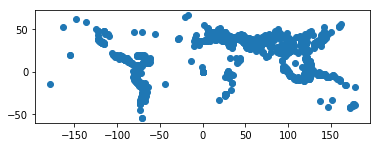

In [21]:
# Basic plot
gdf.plot()

In [23]:
earthquake_df['year'] = earthquake_df.index.year
earthquake_df['month'] = earthquake_df.index.month
earthquake_df['day'] = earthquake_df.index.day

earthquake_df.head()

Present-day country and link to Wikipedia article     Lat  \
Origin (UTC)                                                                    
1900-05-11 17:23:00                                             Japan  38.700   
1900-07-12 06:25:00                                            Turkey  40.300   
1900-10-29 09:11:00                                         Venezuela  11.000   
1901-02-15 00:00:00                                             China  26.000   
1901-03-31 07:11:00                                          Bulgaria  43.400   

                        Long Depth (km)  Magnitude Secondary Effects  \
Origin (UTC)                                                           
1900-05-11 17:23:00  141.100          5        7.0               NaN   
1900-07-12 06:25:00   43.100        NaN        5.9               NaN   
1900-10-29 09:11:00  -66.000          0        7.7               NaN   
1901-02-15 00:00:00  100.100          0        6.5               NaN   
1901-03-31 07:11:00   28.700        NaN        6.4               NaN   

                     PDE Shaking Deaths  PDE Total Deaths  Utsu Total Deaths  \
Origin (UTC)                                                                   
1900-05-11 17:23:00                -1.0              -1.0               -1.0   
1900-07-12 06:25:00                -1.0              -1.0              140.0   
1900-10-29 09:11:00                -1.0              -1.0               -1.0   
1901-02-15 00:00:00                -1.0              -1.0               -1.0   
1901-03-31 07:11:00                -1.0              -1.0                4.0   

                     EM-DAT Total Deaths  Other Source Deaths  deaths  \
Origin (UTC)                                                            
1900-05-11 17:23:00                 -1.0                  NaN    -1.0   
1900-07-12 06:25:00                 -1.0                  NaN   140.0   
1900-10-29 09:11:00                 -1.0                  NaN    -1.0   
1901-02-15 00:00:00                 -1.0                  NaN    -1.0   
1901-03-31 07:11:00                 -1.0                  NaN     4.0   

                               geometry  year  month  day  
Origin (UTC)                                               
1900-05-11 17:23:00  POINT (141.1 38.7)  1900      5   11  
1900-07-12 06:25:00   POINT (43.1 40.3)  1900      7   12  
1900-10-29 09:11:00      POINT (-66 11)  1900     10   29  
1901-02-15 00:00:00    POINT (100.1 26)  1901      2   15  
1901-03-31 07:11:00   POINT (28.7 43.4)  1901      3   31

In [24]:
earthquake_df['Depth (km)'].fillna(value=-1, inplace=True)
earthquake_df['Depth (km)'].replace(to_replace='?', value=-1, inplace=True)

earthquake_df['Depth (km)'] = earthquake_df['Depth (km)'].astype(float)

In [25]:
earthquake_df['lat'] = lat
earthquake_df['lng'] = lng

earthquake_df.drop(columns=['geometry'], axis=1, inplace=True)

In [26]:
earthquake_df.reset_index(inplace=True)
earthquake_df.drop(columns=['Origin (UTC)'], axis=1, inplace=True)

earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 17 columns):
Present-day country and link to Wikipedia article    1340 non-null object
Lat                                                  1340 non-null object
Long                                                 1340 non-null object
Depth (km)                                           1340 non-null float64
Magnitude                                            1340 non-null float32
Secondary Effects                                    373 non-null object
PDE Shaking Deaths                                   1340 non-null float32
PDE Total Deaths                                     1340 non-null float32
Utsu Total Deaths                                    1340 non-null float32
EM-DAT Total Deaths                                  1340 non-null float32
Other Source Deaths                                  37 non-null float64
deaths                                               1340 non-null float64


In [27]:
# Most of the following code is based off the example from this repository on how to embed javascript into your notebook
# https://github.com/cmoscardi/embedded_d3_example

earthquakes_json = earthquake_df.to_json()

from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript('window.earthquakesObj={};'.format(earthquakes_json))

<IPython.core.display.Javascript object>

In [28]:
%%javascript
/*
 * As it turns out, pandas returns a dictionary with 
 * the top-level keys as the column headers, and values
 * as the list of values under that column.
 * I'd recommend looking yourself.
 * This function, in JS, converts to what D3 wants.
 * Of course we could also easily do this on the python side.
 */
function convertPlotData(data){
  var convertedData = [];
  //pandas gives each column the same number of
  //objects, arbitrarily choose one to iterate over
  for(var i in data[Object.keys(data)[0]]){
    var convertedDatum = {};
    for(var key in data){
      convertedDatum[key] = data[key][i];
    }
    convertedData.push(convertedDatum);
  }
  return convertedData;
}

window.convertPlotData = convertPlotData;

<IPython.core.display.Javascript object>

In [29]:
%%javascript

require.config({
    paths: {
        d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
    }
});

<IPython.core.display.Javascript object>

In [30]:
%%javascript
// console.log(require.s.contexts._.defined);
require(['d3'], function(d3){
    console.log('THIS IS d3: ', d3);
    console.log('d3 version: ', d3.version);
   
});


<IPython.core.display.Javascript object>

In [58]:
%%html
<style>
// add your CSS styling here
h1 {
    font-family: sans-serif;
    font-weight: 300;
    font-size: 16px;
}
</style>

In [112]:
%%javascript
require(['d3'], function(d3) {
    
    var width = 800,
        height = 600;
    
    var hTagsFontFamily = 'sans-serif',
        hTagsFontWeight = '300';
   
    //a weird idempotency thing
    $('#chart1').remove();
    //create canvas
    element.append(`
        <div id='chart1' class='row'>
            <div id='map-title' class='row'><h1>Earthquakes 1900-2011</h1></div>            
            <div id='map-container' class='col-md-8'>
                <div id='map'></div>
            </div>
            <div id='stats-container' class='class='col-md-4'>
                <div class='row'>
                    <h2 id='stats-country'>Country: <span id='stats-country-dynamic'></span></h1>
                    <div id='stats-earthquake-dynamic' class='row'><h2 id='stats-earthquake'>Earthquake: </h2></div>
                </div>                
            </div>
        </div>
    `);
    $('#map-title h1').css({ 'font-family': hTagsFontFamily,  'font-weight': hTagsFontWeight, 'font-size': '40px'});
    
    // add tooltip
    var tooltip = d3.select('#map').append('div')
        .attr('class', 'tooltip')
        .style('opacity', 0);    
    
    var projection = d3.geo.mercator()
        .scale(104)
        .translate([width / 2.45, height / 2]);
      
    var path = d3.geo.path().projection(projection);
  
    var svg = d3.select('#map').append('svg')
        .attr({
          width: width,
          height: height
        });

    d3.json('custom.geo.json', function(error, json) {
        console.log(json.features);
        
        // Draw each province as a path
        svg.selectAll('path')
            .data(json.features)
            .enter().append('path')
                .attr({
                    'd': path,
                    'id': function(d) {return d.properties.name;},
                    'class': function(d) { return ['continent', d.properties.continent]; }
                })
                .style({
                    'fill': '#666',
                    'stroke-opacity': .4,
                    'stroke': '#D3D3D3'
                })
                .on('mouseover', function(d) {
                    d3.select( this )
                        .transition()
                        .style({
                            'stroke-opacity': 1,
                            'stroke': '#f00',
                            'fill': 'pink'
                        });
            
                    $( '#stats-country-dynamic' ).text( d.properties.name ) ;
                })
                .on('mouseout', function(d) {
                    d3.select(this)
                        .transition()
                        .style({
                            'stroke-opacity': .4,
                            'stroke': '#D3D3D3',
                            'fill': '#666'
                        });
            
                    $('#stats-country-dynamic').text( ' ' );
                });
        
        d3.json('data/earthquakes_json.json', function(error, earthquakes_data) {            
            var converted_earthquakes = [];
            var eq_keys = Object.keys(earthquakes_data);
            
            for (var i = 0; i < Object.keys(earthquakes_data['lat']).length; i++) {
                var data_point = new Object();
                
                for (var j = 0; j < eq_keys.length; j++) {
                    var key = eq_keys[j];
                    var value = earthquakes_data[eq_keys[j]][i];
                    if ((key == 'Lat' || key == 'Long')) {
                        if ((value == '?' || value == '??' || value == 0)) {
                            data_point = 0;
                            break;
                        } else {
                            value = parseFloat(value);
                        }

                    }
                    
                    data_point[key] = value;
                }
                if (data_point !== 0) {
                    converted_earthquakes.push(data_point);
                }                
            }
            console.log('converted_earthquakes: ', converted_earthquakes);
            
            svg.selectAll('circle')
                .data(converted_earthquakes).enter()
                .append('circle')
                .attr({
                  cx: function(d) { return projection([d.Long, d.Lat])[0]; },
                  cy: function(d) { return projection([d.Long, d.Lat])[1]; },
                  r: function(d) { 
                      if (d.Magnitude == -1) {
                          return 0;
                      } else {
                          return Math.sqrt(d.Magnitude);;
                      }    
                  },
                  'class': 'earthquake'
                })
                .style('fill', 'red')
                .on('mouseover', function(d) {
                    console.log(d);
                
                    var $earthquakeStats = `
                        <ul>
                            <li><strong>Time of event: ${d.day}/${d.month}/${d.year}</strong></li>
                            <li><strong>Magnitude: ${d.Magnitude}</strong></li>
                            <li><strong>Total Deaths: ${d.deaths}</strong></li>
                            <li><strong>Depth: ${d['Depth (km)']}(km)</strong></li>
                        </ul>
                    `;
                
                    $( '#stats-earthquake-dynamic' ).append( $earthquakeStats );
//                     tooltip.transition()
//                         .duration(300)
//                         .style('opacity', .85);
            
//                     tooltip.html(`
//                         <ul>
//                             <li><strong>Time of event: ${d.day}/${d.month}/${d.year}</strong></li>
//                             <li><strong>Magnitude: ${d.Magnitude}</strong></li>
//                             <li><strong>Total Deaths: ${d.deaths}</strong></li>
//                             <li><strong>Depth: ${d['Depth (km)']}(km)</strong></li>
//                         </ul>
//                     `)
//                         .style('left', (d3.event.pageX) + 'px')
//                         .style('top', (d3.event.pageY - 28) + 'px');
                })
                .on('mouseout', function(d) {
//                     tooltip.transition()
//                         .duration(300)
//                         .style('opacity', 0);
                
                    $( '#stats-earthquake-dynamic ul' ).remove();
                });
            });
            
            console.log(svg.selectAll('circle'));
    });
});

<IPython.core.display.Javascript object>

In [37]:
%%html
<style>
.ticks {
  font: 10px sans-serif;
}

.track,
.track-inset,
.track-overlay {
  stroke-linecap: round;
}

.track {
  stroke: #000;
  stroke-opacity: 0.3;
  stroke-width: 10px;
}

.track-inset {
  stroke: #ddd;
  stroke-width: 8px;
}

.track-overlay {
  pointer-events: stroke;
  stroke-width: 50px;
  stroke: transparent;
  cursor: crosshair;
}

.handle {
  fill: #fff;
  stroke: #000;
  stroke-opacity: 0.5;
  stroke-width: 1.25px;
}
</style>

In [45]:
%%javascript
require(['d3'], function(d3) {
    
    //a weird idempotency thing
    $('#chart1').remove();
    //create canvas
    element.append("<div id='chart1'></div>");
    $('#chart1').width('800px');
    $('#chart1').height('800px');

    console.log(d3.version);
    
    d3.slider().axis(true).min(2000).max(2100).step(5)
    
});

<IPython.core.display.Javascript object>

In [86]:
%%javascript
console.log(require.s.contexts._.defined);

<IPython.core.display.Javascript object>